# Exploratory Data Analysis of Online University Student data and Their Course Outcomes

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from dython.nominal import associations
import os
import sys
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
from importlib import reload
from src.functions import load_OU_data, CourseScaler
import warnings
warnings.filterwarnings("ignore")
sns.set_style('whitegrid')

In [19]:
def dist_by_course(column):
    """
    Takes the name of a column as a string, then creates a histogram of the distribution 
    of values for that column for each course and a KDE plot comparing them all.
    """
    if regs[column].dtype == 'object':
        return "Please choose a numerical column"
    fig, axes = plt.subplots(4,2, figsize=(10,20), sharex=True, sharey=True)
    axes = axes.ravel()
    for i, course in enumerate(regs['code_module'].unique()):
        course_plot = regs[regs['code_module'] == course]
        sns.histplot(data=course_plot, x=column, 
                    palette='husl', stat='density',
                    ax = axes[i]).set_title(f'Distribution of {column} in Course {course}')
    plt.show()
    sns.kdeplot(data=regs, x=column, hue='code_module', common_norm = False,
                 palette='husl').set_title(f'Comparative Distribution of {column} Between Courses')

In [21]:
def registration_correlations(prediction_window=None, scaled=False, drop_course=False):
    """
    Loads registrations and creates a dython correlation chart.
    prediction_window: (int) how far into the course the dataframe should include
    scaled: (boolean) whether to use CourseScaler to scale data by course.
    """
    
    df = load_OU_data(prediction_window=prediction_window)
    df.loc[df['final_result'] == 'Withdrawn', 'final_result'] = 0
    df.loc[df['final_result'] == 'Fail', 'final_result'] = 1
    df.loc[df['final_result'] == 'Pass', 'final_result'] = 2
    df.loc[df['final_result'] == 'Distinction', 'final_result'] = 3
    
    df.loc[df['age_band'] == '0-35', 'age_band'] = 0
    df.loc[df['age_band'] == '35-55', 'age_band'] = 1
    df.loc[df['age_band'] == '55<=', 'age_band'] = 2
    
    columns = ['code_presentation','id_student','module_presentation_length']
    if prediction_window == None:
        columns.append('date_unregistration')
    variables = df.drop(columns = columns)
    if scaled:
        cs = CourseScaler(drop_course=drop_course)
        variables = cs.fit_transform(variables)
    variables['code_module'] = variables['code_module'].astype('str')
    fig, ax = plt.subplots(1,1, figsize = (20,10))
    fig.suptitle('Variable Correlations', fontsize = 30)
    associations(variables, ax=ax, mark_columns=True, cmap = 'coolwarm')
    plt.show()

In [22]:
regs = load_OU_data(prediction_window = None)

In [23]:
regs.head()

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,date_registration,date_unregistration,module_presentation_length,days_studied,activities_engaged,total_clicks,assessments_completed,average_assessment_score
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass,-159.0,268.0,268,40,196,934,5,82.0
1,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,Pass,-53.0,268.0,268,80,430,1435,5,66.4
2,AAA,2013J,31604,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,Pass,-52.0,268.0,268,123,663,2158,5,76.0
3,AAA,2013J,32885,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,Pass,-176.0,268.0,268,70,352,1034,5,54.4
4,AAA,2013J,38053,M,Wales,A Level or Equivalent,80-90%,35-55,0,60,N,Pass,-110.0,268.0,268,143,723,2445,5,68.0


# Distribution of Demographic Data

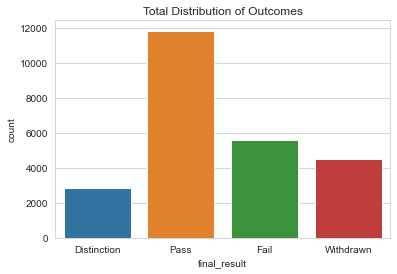

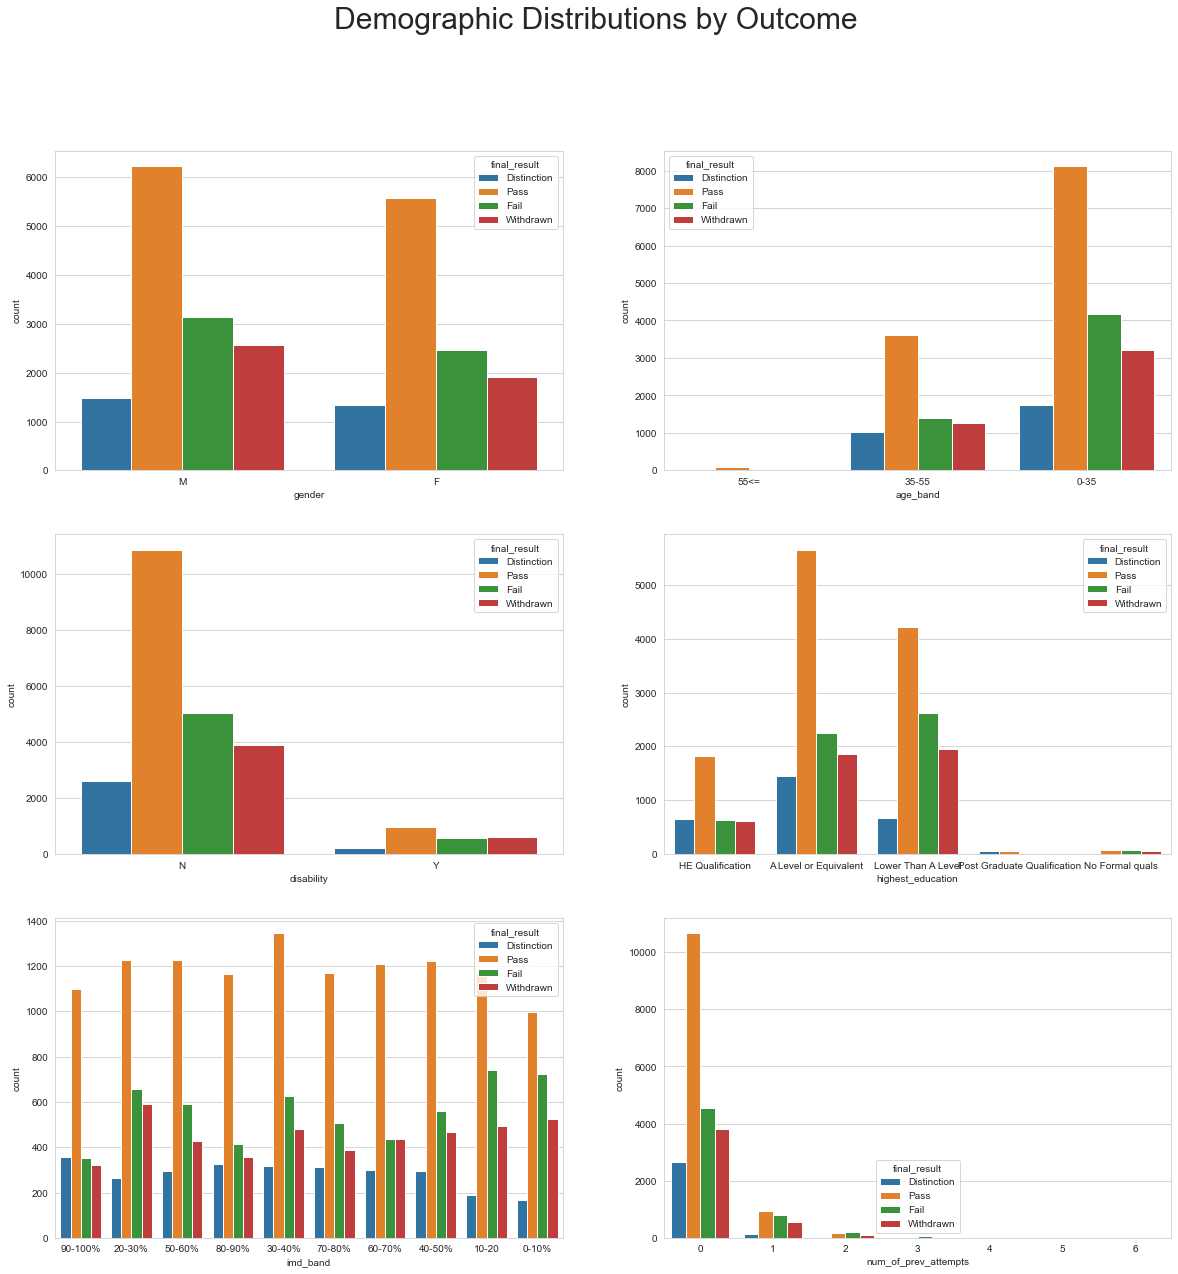

In [52]:
hue_order = ['Distinction','Pass','Fail','Withdrawn']
sns.countplot(data=regs, x='final_result', 
              order = hue_order).set_title('Total Distribution of Outcomes')

demos = ['gender','age_band','disability','highest_education','imd_band','num_of_prev_attempts']

fig, axes = plt.subplots(3,2,figsize = (20,20))
axes = axes.ravel()

for i, col in enumerate(demos):
    sns.countplot(data=regs, x=col, hue='final_result', 
                  hue_order = hue_order, ax=axes[i])
    
fig.suptitle('Demographic Distributions by Outcome', fontsize = 30)
plt.show()


# Distribution of Registrations

Text(0.5, 1.0, 'Distribution of Registrations')

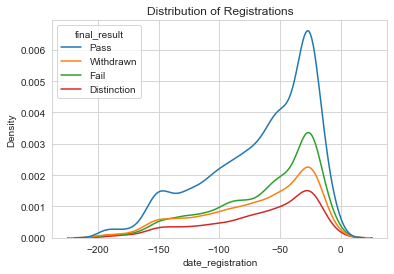

In [25]:
sns.kdeplot(data=regs[(regs['date_registration'] > -200) & (regs['date_registration'] < 0)], 
            x='date_registration', 
            hue = 'final_result').set_title('Distribution of Registrations')

# Cumulative Withdrawals by Date

Text(0.5, 1.0, 'Distribution of Withdrawal Dates')

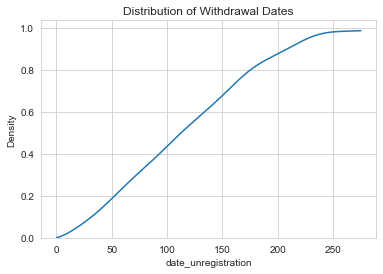

In [46]:
sns.kdeplot(data=regs[regs.final_result == 'Withdrawn'], x='date_unregistration', 
            clip = (0,275), cumulative = True).set_title('Distribution of Withdrawal Dates')

This is a very interesting plot.  This will help us decide our prediction window.  It looks like we can predict about 60 percent of the withdrawals if we use a 100 day prediction window, about 80% of withdrawals if we choose a 50 day prediction window.

# Total Clicks Distribution by Course

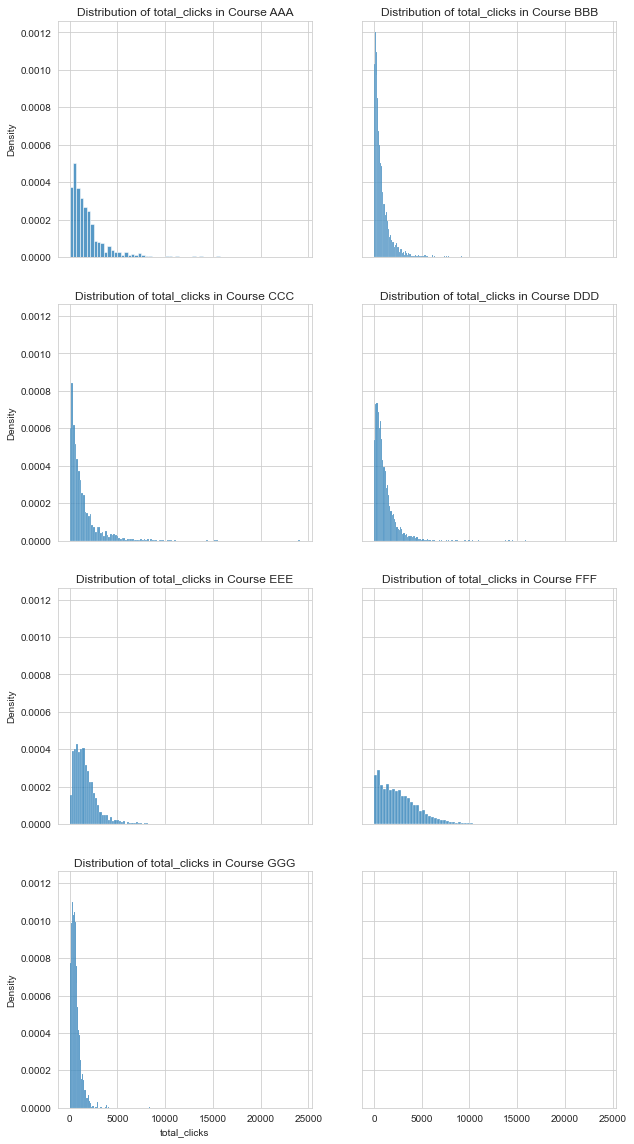

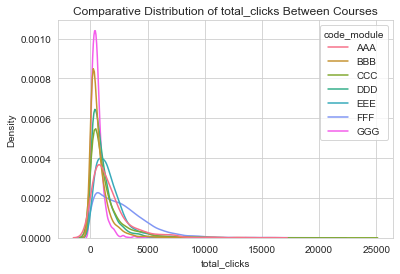

In [27]:
dist_by_course('total_clicks')

We see that total click distributions are far from uniform across courses.  While course 1 is centered around a mean of approximately 10<sup>2.7</sup>, course 5 is closer to 10<sup>3.5</sup>.  A big difference!

# Are Assessments Harder in Some Courses?

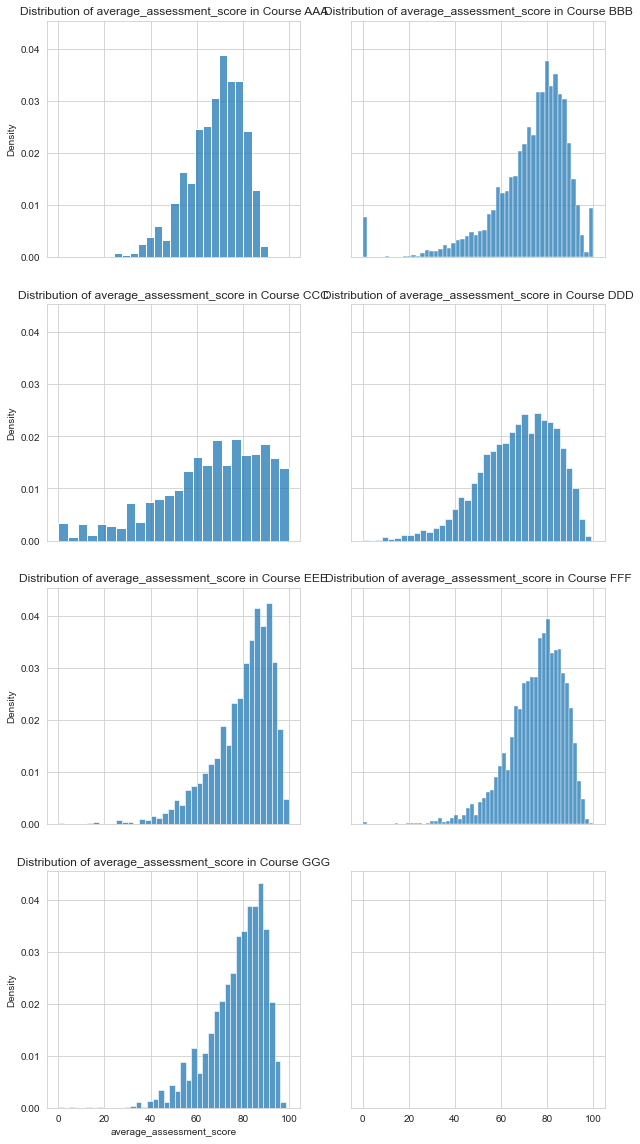

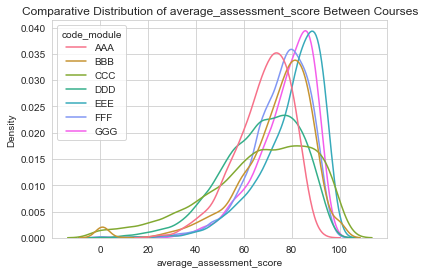

In [28]:
dist_by_course('average_assessment_score')

Indeed, some courses seem to trend toward higher or lower scores.  Some courses also have a stronger tendency toward the mean in scoring while others have a wider distribution.  Course 1 seems to have an oddly large number of 0s and 100s as well.

# Do Courses Have the Same Number of Activities?

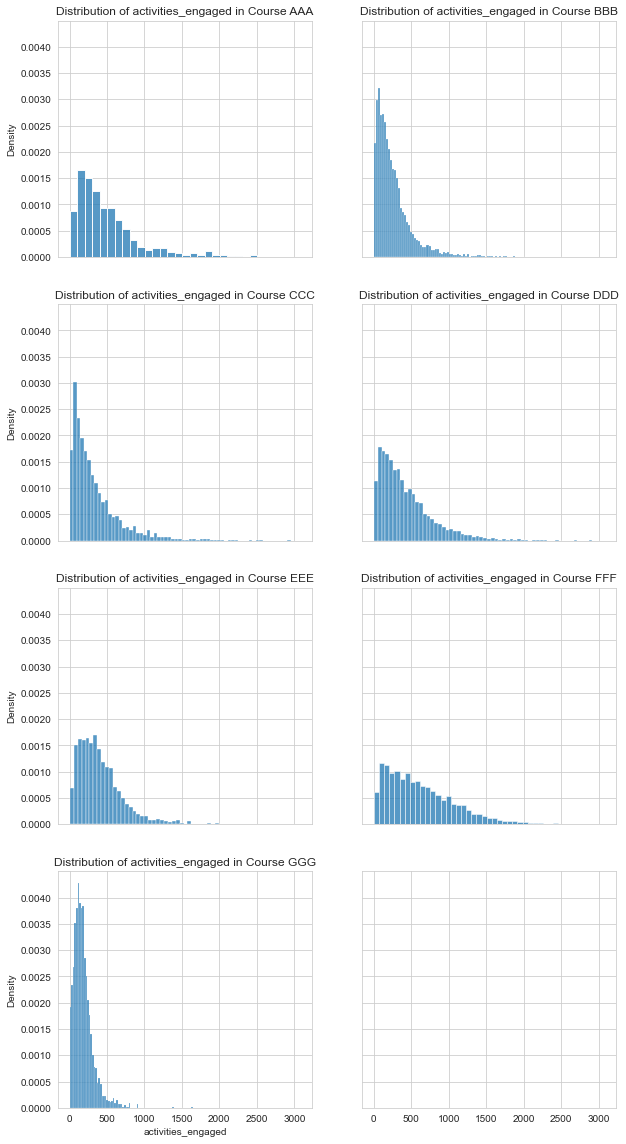

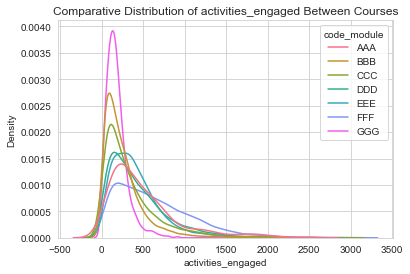

In [29]:
dist_by_course('activities_engaged')

First of all, no!  Courses obviously do not have the same number of activities.  I also think that all activities are not mandatory, since course 2 has a mean number of completed activites in the 10<sup>2</sup> range with outliers nearer the 3*10<sup>3</sup> range!  

# Do students study the same number of days for each course?

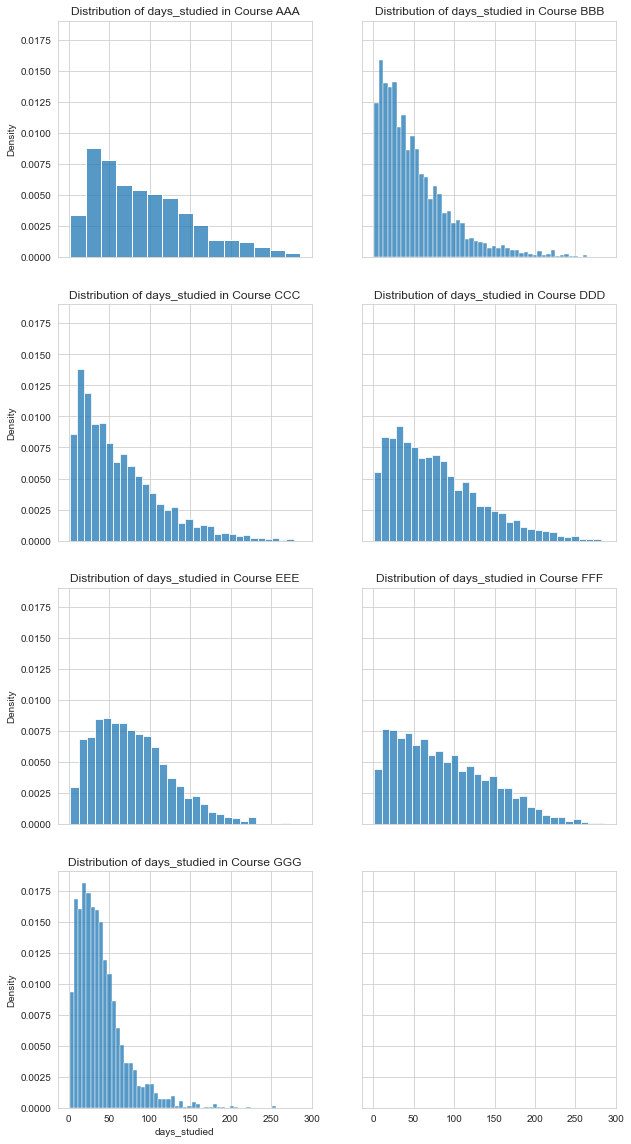

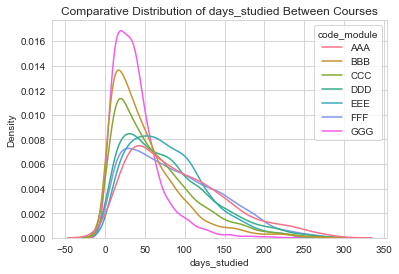

In [30]:
dist_by_course('days_studied')

Wow!  These distributions look very different.  Now I wonder how course modules correlate to other variables?

# Correlations
For this we want to see correlations between variables.  We will use the [dython](https://github.com/shakedzy/dython) package to explore these:

*From dython.associations() documentation:* 

>Calculate the correlation/strength-of-association of features in data-set
with both categorical and continuous features using:
> * Pearson's R for continuous-continuous cases
> * Correlation Ratio for categorical-continuous cases
> * Cramer's V or Theil's U for categorical-categorical cases

We want to see which variables positively affect outcomes and which negatively effect outcomes.  For modeling we want those outcomes to be categorical, but for these correlations we can make them ordinal.  

Distinction > Pass > Fail > Withdraw.  

The ordering of the last two is my own bias, I admit.  Better to fail than to quit.

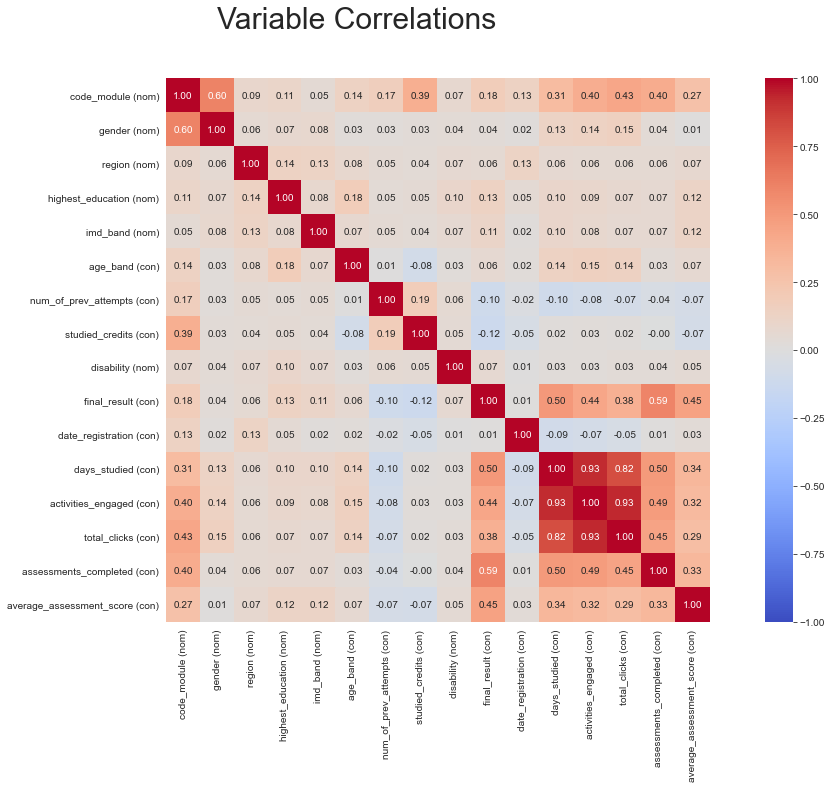

In [31]:
registration_correlations(prediction_window=None)

There are a lot of VERY interesting results here!

1. <ins>**You can better predict who did well in the course by how often they study than by their assessment scores.**</ins>  Other than `assessments_completed`, which seems natural, `final_result` is most highly correlated with `days_studied`.  This is very meaningful because it means the more a student spreads out their studies, the better they are likely to do.  Total clicks and activities completed are also well correlated, as well as assessment scores, but those seem more obvious.
2. <ins>**Women took social sciences courses and men took STEM courses.**</ins> The only strong correlation with gender is...`code_module`!  And, it's quite strongly correlated.  Courses 0, 1, and 6 are social sciences courses and 2-5 are STEM courses.  We can clearly see by the graph below that men are more prevelant in the STEM courses and women in the social sciences courses, except for course 0, which only did not have a lot of students in total. The disparity is extreme.
3. <ins>**Some courses are harder than others.**</ins> `code_module` is also well correlated with `studied_credits` and the activity statistics (5 rows on the far right).  Based on this and our previous course by course distributions, I would say some courses were more demanding that others, or they attracted students who did more work.
4. <ins>**Taking a greater courseload or repeating courses makes a student less likely to succeed.**</ins>.  `num_of_prev_attempts` is slightly negatively correlated all activity statistics and both it and `studied_credits` are negatively correlated to `final_results`.  It makes sense that taking too high a courseload would weigh down on a student.  On the other hand, one might imagine that students who repeat courses would do better in them.  `num_of_prev_attempts` is even negatively correlated to `average_assessment_score`.  This seems to indicate that there are other variables affecting some students' ability to be successful in the course.  I imagine this might be situations outside of the school and outside of the scope of this dataset.  
5. <ins>**Living in a less deprived neighborhood helps students succeed**.</ins> There is a positive correlation between `imd_band`, which is a measure of relative deprivation, and `final_result`, `days_studied` and `average_assessment_score`.  Higher numbers on the `imd_band` signify less deprivation in the students' neighborhood compared to neighborhoods around them.  Also, interestingly, women in these coruses seem to be more likely to live in more deprived neighborhoods.
6. <ins>**Older students work harder.**</ins> age_band, when changed into an ordinal variable with higher values meaning older students, correlates positively with `days_studied`, `activities_engaged`, and `total_clicks`.  This means that older students are spending more days studying and doing more of the work.  However, it does not as strongly correlate with higher assessment scores or better final outcomes.

Text(0.5, 1.0, 'Courses by Gender Count')

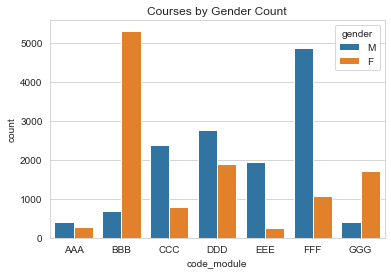

In [32]:
sns.countplot(data=regs, x='code_module', hue='gender').set_title('Courses by Gender Count')

We saw earlier that 20% of students who withdraw after the start of the presentation do so before the 50th day and 40% do so before the 100th day.  We are not actually interested in predictive statistics using data for the entire course because our purpose is to intervene with students before the end.  Let's take a look at which of these correlations hold up when only considering data from the beginning of the course, either the first 50 days or the first 100 days.

# First 50 Days

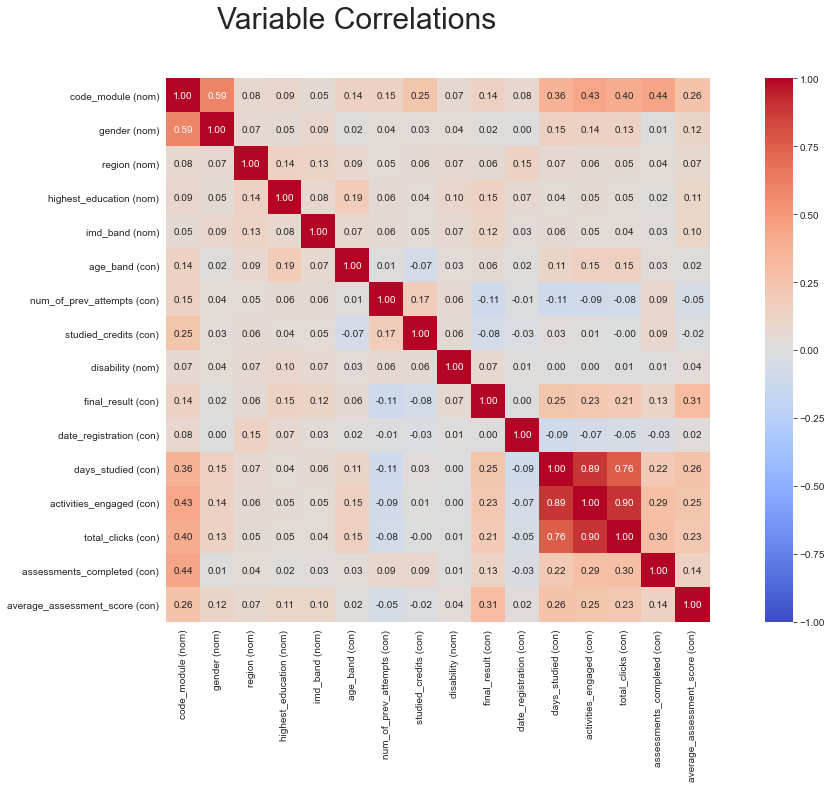

In [33]:
registration_correlations(prediction_window=50)

Well, we can no longer say that `days_studied` is more predictive than `average_assessment_score`, however it is close.  Also, the number of assessments completed 50 days into the course is much less correlated to the average scores on them (from .33 down to .14).  This is most likely because students who did not complete all assessments by the end of the course were students who withdrew, and we might suspect that students who are on track to fail or withdraw might be getting lower assessment scores, especially by the end of the course.  In fact, since we see that assessment scores, even in the first 50 days, are correlated to final results, we might suspect that 

# First 100 Days

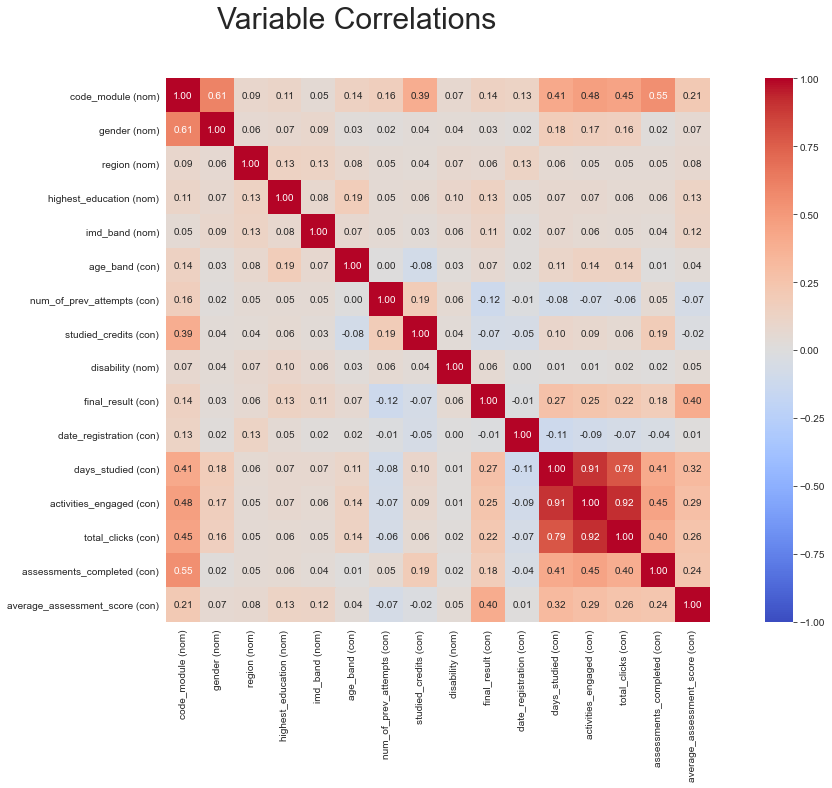

In [34]:
registration_correlations(prediction_window=100)

It seems that assessment scores become more important as a predictor of student success further into the course.  Correlation between `average_score` and `final_result` went up, as did the correlation between the number of assessments students completed and their scores.  Days studied also gained in importance in the interval between 50 days and 100 days of course time.

# Normalizing Data by Course

## Full Dataset

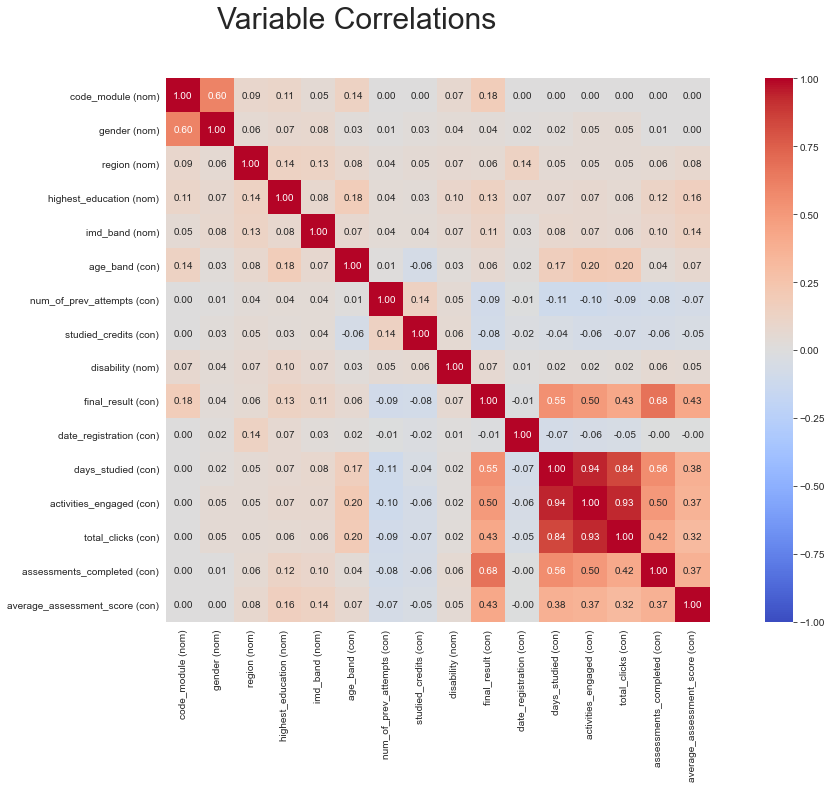

In [35]:
registration_correlations(prediction_window=None, scaled=True)

When we scale continuous variables by the means and standard deviations for each course, thereby normalizing the differences between courses, we see that the importance of the activity statistics jumps up, as does the correlation between number of assessments completed and the average scores on them.  The slight correlations between `gender` and `days_studied`, `activities_complete` and `total_clicks` also goes away.  I wonder if this was a result of the correlation between gender and code_module and code_module and activity stats?

# 50 Days Into the Course

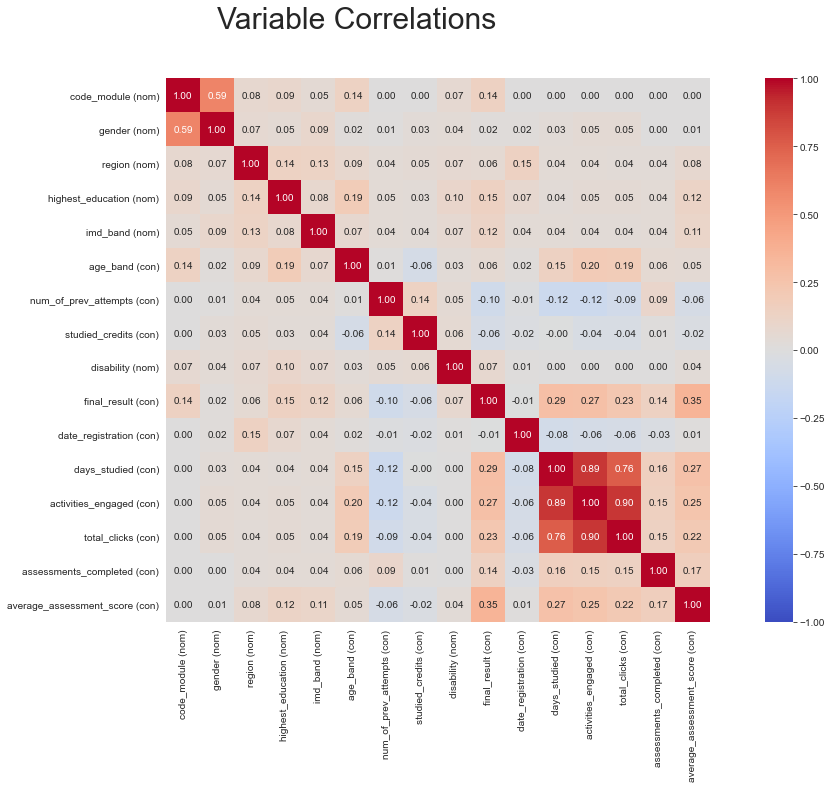

In [36]:
registration_correlations(prediction_window=50, scaled=True)

Activity stats above are less strongly correlated with final outcomes, but as we can see from the full dataset and 100 days in, these become increasingly important in predicting student success.  It looks like it might be a little easier to get away with slacking at the beginning, but if you haven't established good study habits by later in the course, your chances of succeeding fall as time goes on.

## 100 Days Into the Course

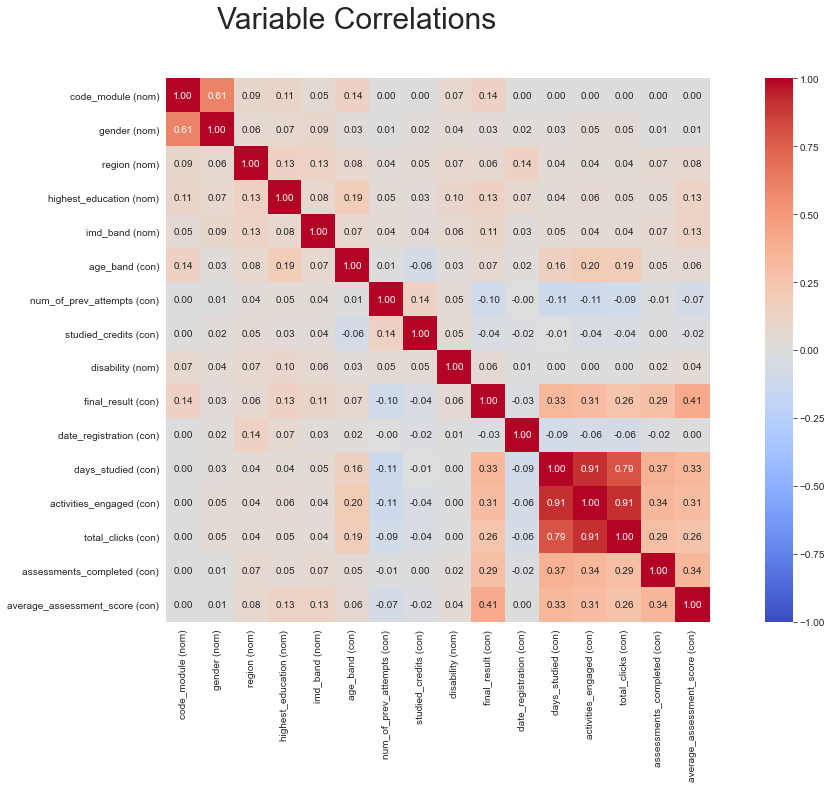

In [37]:
registration_correlations(prediction_window=100, scaled=True)

# What should our prediction window be?

It's a hard choice between using 50 or 100 days of data for our prediction window.  Any more loses too many withdrawing students and any less doeesn't give enough data to predict on.  The function for the loss of students creates a pretty straight line, with the courses losing about 20% of their students about every month or so after the first 50 days.  I think we will have to see how the models do on different prediction windows to really make a decision.

Text(0.5, 1.0, 'Distribution of Withdrawal Dates')

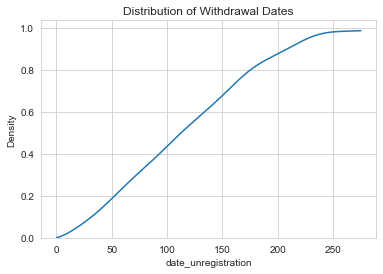

In [48]:
sns.kdeplot(data=regs[regs.final_result == 'Withdrawn'], x='date_unregistration', 
            clip = (0,275), cumulative = True).set_title('Distribution of Withdrawal Dates')